In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['seaborn-talk', 'seaborn-ticks'])

import cartopy.crs as ccrs

import numpy as np
import pandas as pd
import xarray as xr

import warnings; warnings.simplefilter('ignore')

# Frame et al (2017) and Hawkins and Sutton (2012) Reproduction


Here we want to derive some code to calculate the ToE S/N metrics used on both of these two studies. We don't quite have access to fully transient runs, but we *do* have the ability to look at an ensemble of ACCMIP models, Fernando's ensemble, etc.

As an example, let's load the TAS data from an ACCMIP simulation.

In [30]:
from os.path import join
import glob
from dask.diagnostics import ProgressBar

model = "GFDL-AM3"
exp = "accrcp45"

field = "vmro3"
fns_exp = glob.glob(join("../data/accmip", model, exp,
                         field, field+"*.nc"))
fns_hist = glob.glob(join("../data/accmip", model, 'acchist',
                          field, field+"*.nc"))

def _pp(ds):
    return ds[[field, ]].isel(lev=0)

with ProgressBar():
    data_exp = xr.open_mfdataset(fns_exp, preprocess=_pp).load()
    data_hist = xr.open_mfdataset(fns_hist, preprocess=_pp).load()

data = xr.concat([data_hist, data_exp], 'time')

[########################################] | 100% Completed |  5.0s
[########################################] | 100% Completed |  4.3s


## Calculate $\tilde{T}_\mathrm{global}$(t)

Compute monthly anomalies and then yearly average over them, and use them to construct a smoothed timeseries of global average values.

In [31]:
from darpy import global_avg

def _monthly_anom(ds):
    grouped = ds.groupby('time.month')
    return grouped - grouped.mean('time')

data_glbl = global_avg(data).pipe(_monthly_anom)
data_glbl = data_glbl.to_dataframe()

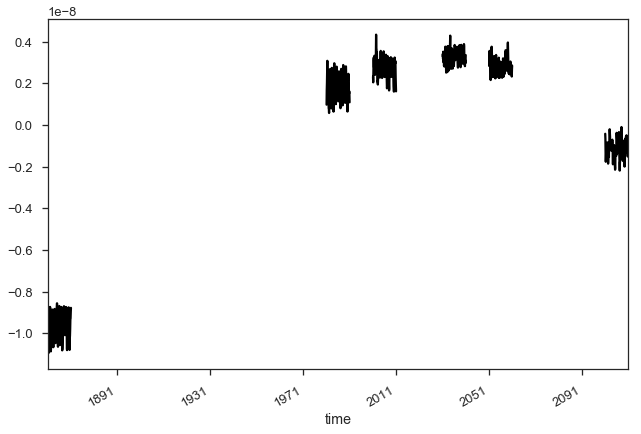

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)

for ylo, yhi in [(1860, 1871), (1980, 1991), (2000, 2011), 
                 (2030, 2041), (2050, 2061), (2100, 2111)]:
    _data = (
        data_glbl
        .loc["{}".format(ylo):"{}".format(yhi)]
    )
    # print(ylo, yhi, len(_data))
    _data[field].plot(ax=ax, color='k')

Prep the global data

In [33]:
def _yearly_mean(ds):
    return ds.groupby('time.year').mean('time')

data_anom = (
    data
    .pipe(_monthly_anom)
    .pipe(_yearly_mean)
    .load()
)
data_anom_glbl = global_avg(data_anom).load()

Fit a 4th-order polynomial to the global average data

In [34]:
y = data_anom_glbl[field].data
x = data_anom_glbl['year'].data
p = np.polyfit(x, y, 4)

def _model(x, p):
    y_hat = 0
    for i, pi in enumerate(reversed(p)):
        y_hat += x**i * pi
    return y_hat

xs = range(x[0], x[-1])
y_hat = [_model(xi, p) for xi in xs]

(-1e-08, 1e-08)

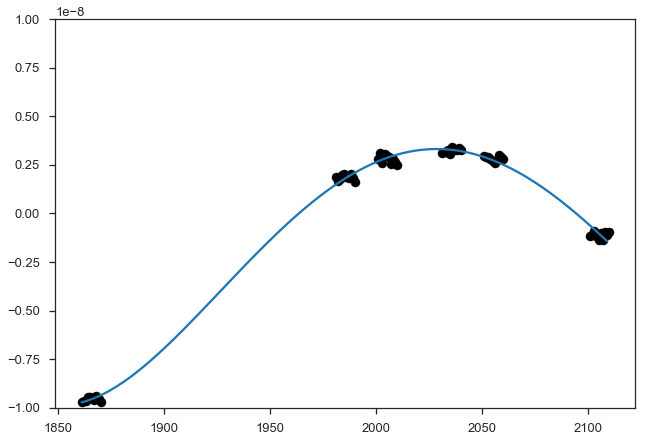

In [37]:
plt.scatter(x, y, color='k')
plt.plot(xs, y_hat)
plt.ylim(-1e-8, 1e-8)

Save this model

In [17]:
from functools import partial

fit_model = partial(_model, p=p)

## Compute regression coefficients $\alpha$, $\beta$

Now we need to regress the temperature in each grid cell against the global average. To do this we'll stack the grid cells and pass through `np.polyfit`

In [18]:
stacked = data_anom.stack(cell=['lat', 'lon'])
stacked[field].data.shape

(60, 12960)

In [19]:
x = stacked['year'].data
y = stacked[field].data

p = np.polyfit(x, y, 1)
alphas, betas = p

Re-cosntruct into Dataset.

In [20]:
stacked['α'] = (['cell', ], alphas)
stacked['β'] = (['cell', ], betas)

In [21]:
fitted = stacked.unstack('cell')

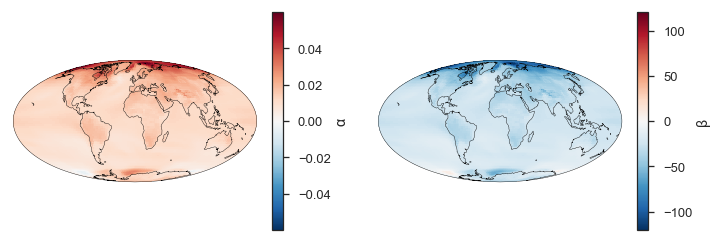

In [22]:
import cartopy.crs as ccrs

fig, axs = plt.subplots(1, 2, figsize=(12, 4), 
                        subplot_kw={'projection': ccrs.Mollweide()})
fitted.α.plot.imshow(ax=axs[0], transform=ccrs.PlateCarree())
fitted.β.plot.imshow(ax=axs[1], transform=ccrs.PlateCarree())

for ax in axs:
    ax.coastlines()


## Project to calculate $S(t)$

Project future temperatures using the fitted model

In [23]:
from ipywidgets import interact, IntSlider

def _future_temp(year):
    plt.clf()
    x = (fitted.α*year + fitted.β)
    x['lon'] = (['lon', ], fitted.lon.values)
    x.plot.imshow(vmin=0, vmax=4)
    plt.show()
    
interact(_future_temp, year=IntSlider(2050, 2000, 2101))

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__._future_temp>

How does the signal for a given year compare versus the actual anomaly?

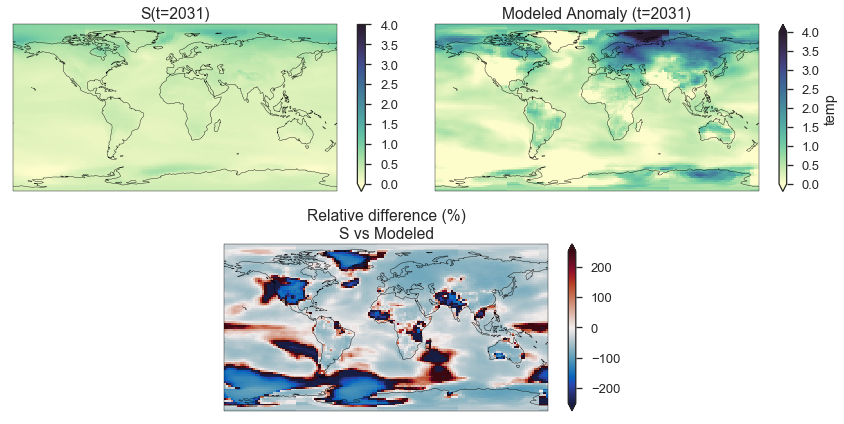

In [24]:
import cartopy.crs as ccrs
import cmocean
from darpy import cyclic_dataarray, shift_lons
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 4)
subplot_kw = dict(projection=ccrs.PlateCarree(), aspect='auto')

axl = fig.add_subplot(gs[0, 0:2], **subplot_kw)
axc = fig.add_subplot(gs[1, 1:3], **subplot_kw)
axr = fig.add_subplot(gs[0, 2:], **subplot_kw)
axs = [axl, axc, axr]

year = 2031

fitted_lon_fix = shift_lons(fitted).roll(lon=len(fitted.lon)//2)
predicted = fitted_lon_fix.α*year + fitted_lon_fix.β
actual = fitted_lon_fix[field].sel(year=year)
diff = 100*(predicted - actual)/actual

cmap_kws = dict(vmin=0, vmax=4, cmap=cmocean.cm.deep)
predicted.plot.imshow(ax=axl, transform=ccrs.PlateCarree(),
                      **cmap_kws)
axl.set_title("S(t={})".format(year))
actual.plot.imshow(ax=axr, transform=ccrs.PlateCarree(),
                   **cmap_kws)
axr.set_title("Modeled Anomaly (t={})".format(year))
cmap_kws = dict(vmin=-250, vmax=250, cmap=cmocean.cm.balance)
diff.plot.imshow(ax=axc, transform=ccrs.PlateCarree(),
                 **cmap_kws)
axc.set_title("Relative difference (%)\nS vs Modeled")

for ax in axs:
    ax.coastlines()
    ax.set_aspect('auto', 'box-forced')
    
plt.tight_layout()


## Calculate $N$

The second half of this analysis task involves computing the $N$ or "noise" term. Hawkins and Sutton are pretty standard here; they simply take the inter-annual standard deviation of whatever unit means we have in our dataset (here, annual means). They do seek to retain the spatial pattern in the interannual variability.

For the ACCMIP data here we can pool the 19th/20th century data to estimate the IAV. Using anything past 2000 probably flirts too much with climate change.

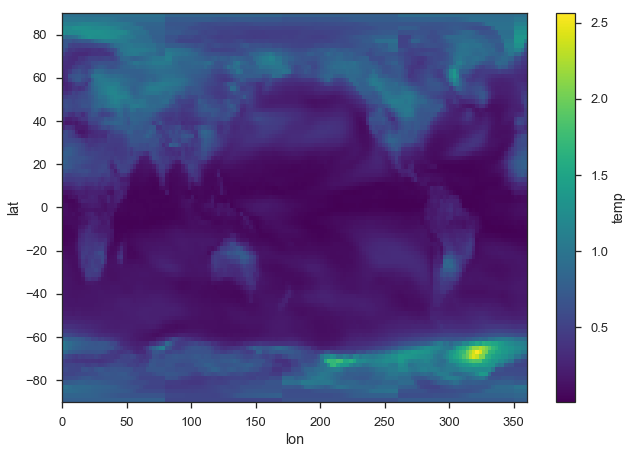

In [25]:
noise = data_anom[field].sel(year=slice(1850, 1991)).std('year')
noise.plot.imshow()

## Putting it all together...

Now we can tie the two together. First we need to create a timeseries of $S(t)$. We can then scale it by $N$, and look at statistics.

In [26]:
years = range(2000, 2101)
Ss = [fitted.α*year + fitted.β for year in years]
S = xr.concat(Ss, 'year')
S['year'] = (['year'], years)

SN = S  / shift_lons(noise)
SN['year'] = (['year'], years)

S = shift_lons(S).roll(lon=len(S.lon)//2)
SN = shift_lons(SN).roll(lon=len(SN.lon)//2)

signal_ds = xr.Dataset({'S': S, 'SN': SN})

Mean SN over indicated time periods.

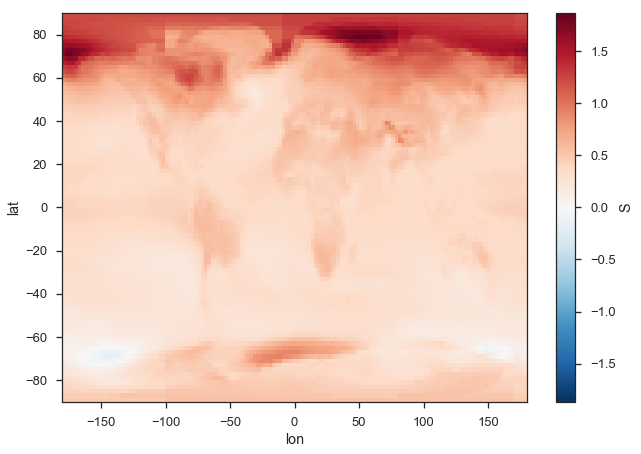

In [27]:
signal_ds['S'].sel(year=slice(2030, 2050)).mean('year').plot.imshow()

## Calculate ToE

The easiest way to calculate the year of emergence is just to loop over the time index of the data and record whenever the values in each grid cell are larger than a given threshold.

In [28]:
import pandas as pd

template = signal_ds['S'].isel(year=0).data
toe_s = np.zeros_like(template)

toe_das = []
ratios = 1, 2, 3
for ratio in ratios:
    toe_s = np.zeros_like(template)
    for year in signal_ds.year:
        _sn_year = signal_ds['SN'].sel(year=year).data
        toe_s[(toe_s == 0) & (_sn_year > ratio)] = year
    # Mask out zeros
    toe_s = np.ma.masked_equal(toe_s, 0)
    toe_da = xr.DataArray(toe_s, 
                          dims=['lat', 'lon'], 
                          coords=[signal_ds.lat, signal_ds.lon])
    toe_das.append(toe_da)

toe_ds = xr.concat(toe_das, dim=pd.Index(ratios, name='ratio'))
toe_ds.name = 'TOE'
signal_ds['TOE'] = toe_ds

Maps of time of emergence

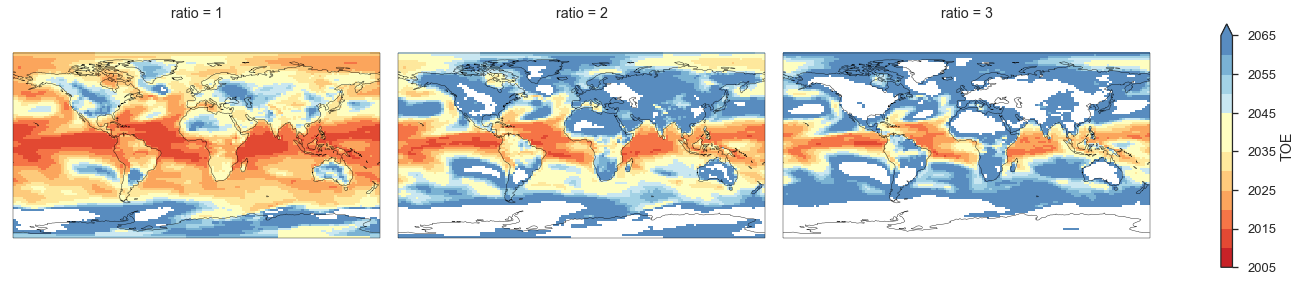

In [29]:
from darpy.plot import get_figsize

nrows, ncols = 1, 3
size, aspect = 4., 16./10.
figsize = get_figsize(nrows, ncols, size, aspect)

g = signal_ds['TOE'].plot.imshow(x='lon', y='lat', col='ratio',
                                 vmin=2005, vmax=2065, levels=13,
                                 cmap="RdYlBu",
                                 aspect=aspect, size=size,
                                 subplot_kws=dict(projection=ccrs.PlateCarree(),
                                                  aspect='auto'),
                                 transform=ccrs.PlateCarree())
for ax in g.axes.ravel():
    ax.coastlines()
    ax.set_aspect('auto', 'box-forced')

# Extension to FGM ensemble

We now extend this calculation to Fernando's ensemble, with the goal of applying it to assess climate-forced air quality data.

We begin by loading the summer timeseries for **TREFHT** previously processed from the ensemble.

In [28]:
field = 'TREFHT'
season = 'JJA'
scale = 1.

data = xr.open_dataset("../data/processed/seasonal_timeseries/fgm.{}.{}.nc"
                       .format(field, season))*scale
data = data.squeeze()

This isn't in a proper "timeseries" format. The three "decadal" slices are stacked on a coordinate axis, and all the timestamps are uniform (and de-referenced such that they're just an integer year). The easiest way to fix this is to split the dataset apart on **dec** and then re-construct it, which will also let us deal with the fact that the 1980-2010 data for **pol=REF** should be used for all the other values of **pol**, too.

In [29]:
dec_dict = {}
decs = data.dec.values.astype(str)

for dec in decs:
    _d = data.sel(dec=dec).copy()
    low, hi = map(int, dec.split("-"))
    _d.time.values = range(low+1, hi+1)
    dec_dict[dec] = _d

In [30]:
pol_dict = {}
pols = data.pol.values.astype(str)

for pol in pols:
    _p = xr.concat([dec_dict['1980-2010'].sel(pol='REF'),
                    dec_dict['2035-2065'].sel(pol=pol),
                    dec_dict['2085-2115'].sel(pol=pol)],
                   dim='time')
    del _p['pol'], _p['dec']
    _p['pol'] = pol
    _p.set_coords(['pol', ], inplace=True)
    
    pol_dict[pol] = _p

In [31]:
merged = xr.auto_combine([pol_dict[pol] for pol in pols], 'pol')

Final post-processing on merged dataset.

In [32]:
from darpy import shift_lons

merged = shift_lons(merged).roll(lon=len(merged.lon)//2 - 1)


## Global average timeseries

Plot some global averages as a test

In [33]:
from darpy import global_avg

mga = global_avg(merged)
mga = mga.where(mga > 0)

mga_df = (
    mga
    .to_dataframe()
    .dropna(subset=[field, ])
    .sortlevel()
)

/Users/daniel/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)


Pad the missing years. To do this, we're just going to re-index the data and manually fill in all the missing years (following [this example](https://stackoverflow.com/questions/14856941/insert-0-values-for-missing-dates-within-multiindex)).

In [34]:
import pandas as pd

ics, pols, years = mga_df.index.levels
years = sorted(years)
new_years = range(years[0], years[-1]+1)

new_index = pd.MultiIndex.from_product([ics, pols, new_years],
                                       names=mga_df.index.names)
new_mga_df = mga_df.reindex(new_index)
new_mga_df.head()

year      TREFHT
ic pol time                    
1  P37 1981  1981.0  288.444084
       1982  1982.0  288.219567
       1983  1983.0  288.175453
       1984  1984.0  288.265535
       1985  1985.0  288.327971

/Users/daniel/anaconda/lib/python3.5/site-packages/seaborn/algorithms.py:76: RuntimeWarning: Mean of empty slice
  boot_dist.append(func(*sample, **func_kwargs))
/Users/daniel/anaconda/lib/python3.5/site-packages/seaborn/timeseries.py:286: RuntimeWarning: Mean of empty slice
  central_data = estimator(df_c.values, axis=0)


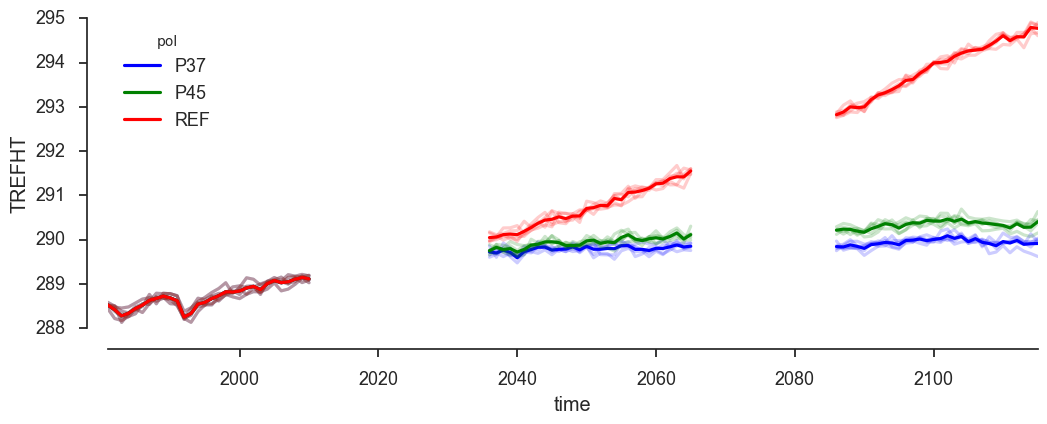

In [35]:
import seaborn as sns

size, aspect = 4., 3.
width, height = size*aspect, size
fig, ax = plt.subplots(1, 1, figsize=(width, height))

ax = sns.tsplot(new_mga_df.reset_index(), time='time', value=field,
                unit='ic', condition='pol', err_style='unit_traces', 
                estimator=np.nanmean, ax=ax)
sns.despine(offset=15)

fn = "../figs/hs2012/fgm.{}.{}.global_timeseries".format(field, season)
plt.savefig(fn+".pdf", transparent=True, bbox_inches='tight')
plt.savefig(fn+".png", transparent=True, bbox_inches='tight', dpi=300)

## Fit Model - single IC / case


In [36]:
from air_quality.models.hawkins_sutton2012 import HawkinsSutton2012

IC = 5
POL = 'P45'

# Prep data
_to_model = merged[field].sel(ic=IC, pol=POL).copy()
_to_model = _to_model.where(_to_model > 0)

baseline = _to_model.sel(time=slice(1981, 2011)).mean('time')
anoms = _to_model - baseline

model = HawkinsSutton2012(anoms)
model.fit()

### Model Check

First, check the patterns of model regression coefficients.

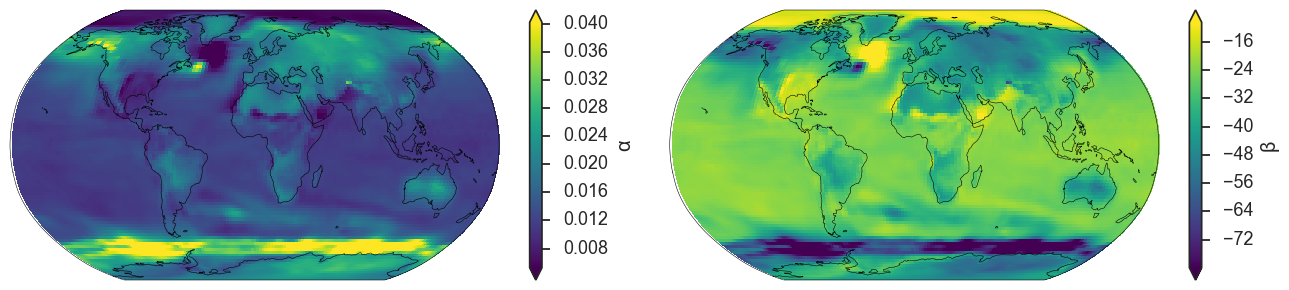

In [37]:
fig, axs = model.plot_coeffs()

fn = "../figs/hs2012/fgm.{}.{}.{}.{}.hs_test.coeffs".format(field, season, IC, POL)
plt.savefig(fn+".pdf", transparent=True, bbox_inches='tight')
plt.savefig(fn+".png", transparent=True, bbox_inches='tight', dpi=300)

Check predictions based on smoothed global average versus actual field

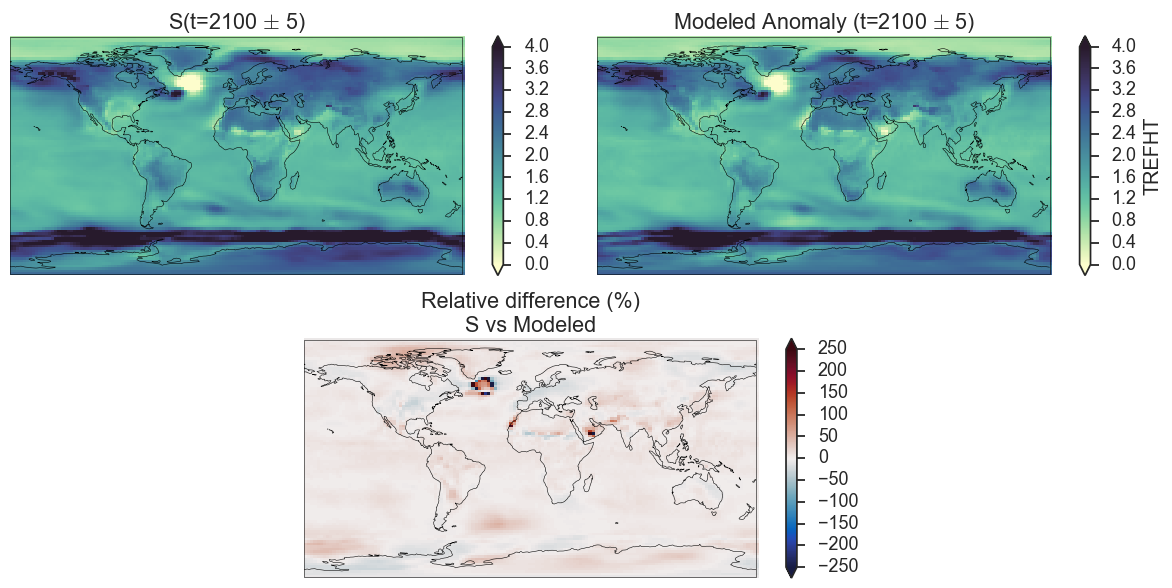

In [38]:
year = 2100
fig, axs = model.plot_prediction_check(year, 5)

fn = "../figs/hs2012/fgm.{}.{}.{}.{}.hs_test.compare_{}".format(field, season, IC, POL, year)
plt.savefig(fn+".pdf", transparent=True, bbox_inches='tight')
plt.savefig(fn+".png", transparent=True, bbox_inches='tight', dpi=300)

### Signal-vs-noise

In [39]:
from air_quality.models.hawkins_sutton2012 import calc_signal_vs_noise

# years = range(1980, 2150)

# Ss = [model.predict(year) for year in years]
# S = xr.concat(Ss, 'year')
# S['year'] = (['year'], years)

# noise = model.data.sel(time=slice(1981, 2011)).std('time')
# SN = S  / noise
# SN['year'] = (['year'], years)

# signal_ds = xr.Dataset({'S': S, 'S_N': SN, 'N': noise})
signal_ds = calc_signal_vs_noise(model)

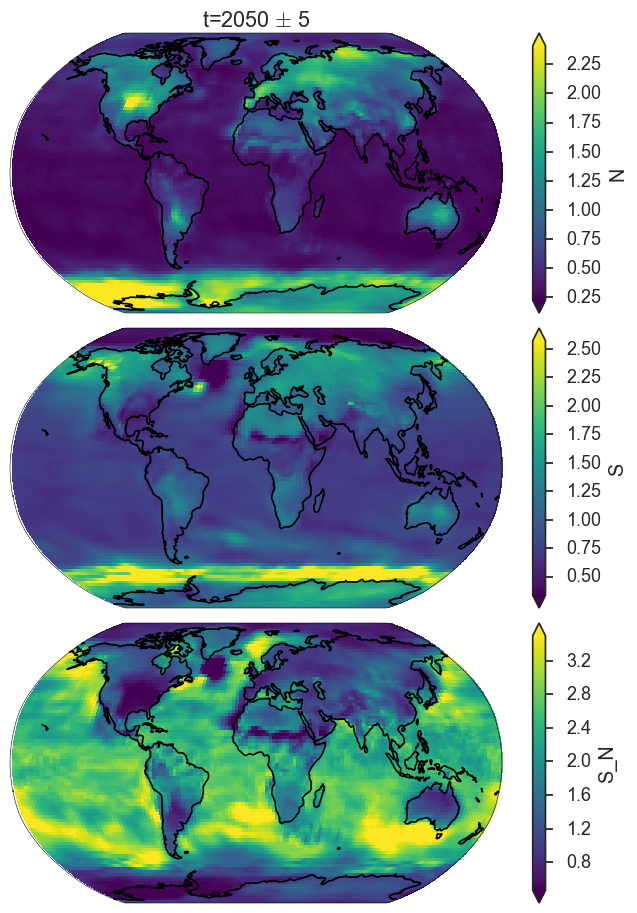

In [40]:
year = 2050
dyear = 5
ylo, yhi = year-dyear, year+dyear

size, aspect = 3., 2.2
nrows, ncols = 3, 1
width, height = size*aspect*ncols, size*nrows

fig, axs = plt.subplots(nrows, ncols, figsize=(width, height),
                        subplot_kw={'projection': ccrs.Robinson()})
axs = axs.ravel()
for sig, ax in zip(['N', 'S', 'S_N'], axs):
    if sig == 'N':
        _to_plot = signal_ds[sig]
    else:
        _to_plot = signal_ds[sig].sel(year=slice(ylo, yhi)).mean('year')
    _to_plot.plot.imshow(ax=ax, robust=True, transform=ccrs.PlateCarree())

for ax in axs:
    ax.coastlines(lw=1.2)
    ax.set_aspect('auto', 'box-forced')
    ax.set_title("")
    # ax.outline_patch.set_visible(False)

plt.tight_layout()
axs[0].set_title("t={} $\pm$ {}".format(year, dyear))

fn = "../figs/hs2012/fgm.{}.{}.{}.{}.hs_test.svn_{}".format(field, season, IC, POL, year)
plt.savefig(fn+".pdf", transparent=True, bbox_inches='tight')
plt.savefig(fn+".png", transparent=True, bbox_inches='tight', dpi=300)

### Time of emergence

In [41]:
from air_quality.models.hawkins_sutton2012 import calc_time_of_emergence

# template = signal_ds['S'].isel(year=0).data
# toe_s = np.zeros_like(template)

# toe_das = []
# ratios = 1, 2, 3
# for ratio in ratios:
#     toe_s = np.zeros_like(template)
#     for year in signal_ds.year:
#         _sn_year = signal_ds['S_N'].sel(year=year).data
#         toe_s[(toe_s == 0) & (_sn_year > ratio)] = year
#     # Mask out zeros
# #     toe_s = np.ma.masked_equal(toe_s, 0)
#     toe_s[toe_s == 0] = year
#     toe_da = xr.DataArray(toe_s, 
#                           dims=['lat', 'lon'], 
#                           coords=[signal_ds.lat, signal_ds.lon])
#     toe_das.append(toe_da)

# toe_ds = xr.concat(toe_das, dim=pd.Index(ratios, name='ratio'))
# toe_ds.name = 'TOE'
# signal_ds['TOE'] = toe_ds

signal_ds['TOE'] = calc_time_of_emergence(signal_ds)

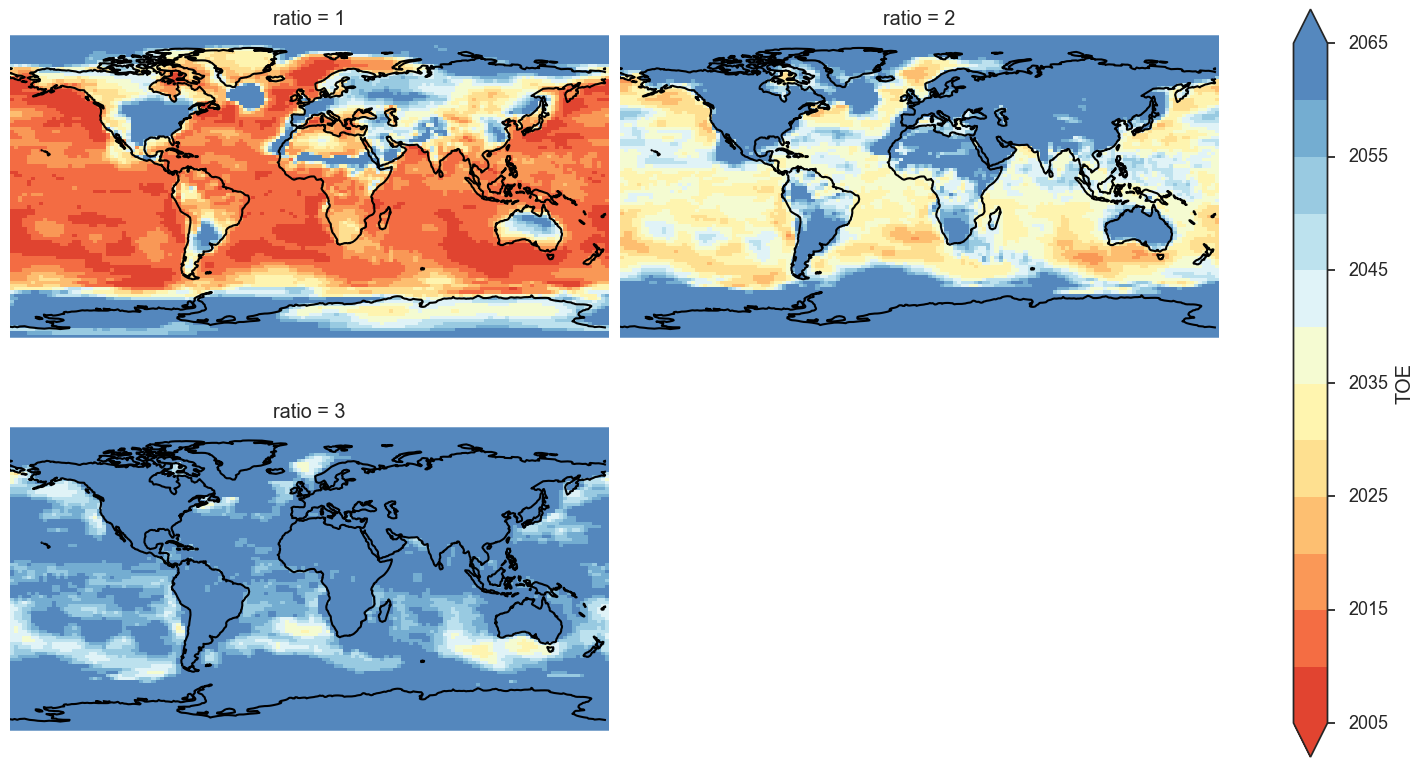

In [42]:
from darpy.plot import get_figsize
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize

nrows, ncols = 2, 2
size, aspect = 4., 1.8 # 16./10.
figsize = get_figsize(nrows, ncols, size, aspect)

cmap_kws = dict(vmin=2005, vmax=2065, levels=13, cmap="RdYlBu",)

g = signal_ds['TOE'].plot.imshow(
    x='lon', y='lat', col='ratio', col_wrap=2,
    aspect=aspect, size=size, **cmap_kws,
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    transform=ccrs.PlateCarree(),
)
for ax in g.axes.ravel():
    ax.coastlines(lw=1.5)
    ax.set_aspect('equal', 'box-forced')
    ax.outline_patch.set_visible(False)
    
# plt.tight_layout()

fn = "../figs/hs2012/fgm.{}.{}.{}.{}.hs_test.toe".format(field, season, IC, POL)
# plt.savefig(fn+".pdf", transparent=True, bbox_inches='tight')
# plt.savefig(fn+".png", transparent=True, bbox_inches='tight', dpi=300)

## Ensemble Analysis

To get a sense of the uncertainty in these estimates, I'm going to apply this calculation to each ensemble member for each policy case. We can probably do more sophisticated boot-strapping in the future, but this will let us get some sense of the uncertainty in these estimates arising from natural variablity, and may help smooth out some of the fields to more easily interpret them.

### Load

Load and re-shape the data for this analysis (unstack along dec and splice 21st century for **P45** and **P37**)

In [43]:
from darpy import shift_lons

field = 'O3_SRF'
season = 'JJA'
scale = 1e9

data = xr.open_dataset("../data/processed/seasonal_timeseries/fgm.{}.{}.nc"
                       .format(field, season))*scale
data = data.squeeze()

dec_dict = {}
decs = data.dec.values.astype(str)

for dec in decs:
    _d = data.sel(dec=dec).copy()
    low, hi = map(int, dec.split("-"))
    _d.time.values = range(low+1, hi+1)
    dec_dict[dec] = _d

pol_dict = {}
pols = data.pol.values.astype(str)

for pol in pols:
    _p = xr.concat([dec_dict['1980-2010'].sel(pol='REF'),
                    dec_dict['2035-2065'].sel(pol=pol),
                    dec_dict['2085-2115'].sel(pol=pol)],
                   dim='time')
    del _p['pol'], _p['dec']
    _p['pol'] = pol
    _p.set_coords(['pol', ], inplace=True)
    
    pol_dict[pol] = _p

merged = xr.auto_combine([pol_dict[pol] for pol in pols], 'pol')
merged = shift_lons(merged).roll(lon=len(merged.lon)//2 - 1)

### Fit Models

In [44]:
from air_quality.models.hawkins_sutton2012 import HawkinsSutton2012, calc_signal_vs_noise, calc_time_of_emergence
from itertools import product
from tqdm import tqdm_notebook, tqdm

iters = product(merged.ic.values, merged.pol.values)
niters = len(merged.ic.values) * len(merged.pol.values)

all_signals = []
for ic in tqdm_notebook(merged.ic.values):
    
    all_pols = []    
    for pol in tqdm_notebook(merged.pol.values, leave=False):

        # Prep data
        _to_model = merged[field].sel(ic=ic, pol=pol).copy()
        _to_model = _to_model.where(_to_model > 0)

        baseline = _to_model.sel(time=slice(1981, 2011)).mean('time')
        anoms = _to_model - baseline

        model = HawkinsSutton2012(anoms)
        model.fit()

        signal_ds = calc_signal_vs_noise(model)
        signal_ds['TOE'] = calc_time_of_emergence(signal_ds, mask=True)
        signal_ds['ic'] = ic
        signal_ds['pol'] = pol

        all_pols.append(signal_ds)
    
    all_pols = xr.concat(all_pols, 'pol')
    all_signals.append(all_pols)
    
all_signals = xr.concat(all_signals, 'ic')

/Users/daniel/anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive
/Users/daniel/workspace/air_quality/src/air_quality/models/hawkins_sutton2012.py:53: RuntimeWarning: invalid value encountered in greater
  toe_s[(toe_s == 0) & (_sn_year > ratio)] = year


/Users/daniel/anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive
/Users/daniel/workspace/air_quality/src/air_quality/models/hawkins_sutton2012.py:53: RuntimeWarning: invalid value encountered in greater
  toe_s[(toe_s == 0) & (_sn_year > ratio)] = year


/Users/daniel/anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive
/Users/daniel/workspace/air_quality/src/air_quality/models/hawkins_sutton2012.py:53: RuntimeWarning: invalid value encountered in greater
  toe_s[(toe_s == 0) & (_sn_year > ratio)] = year


Average over ensemble members

In [45]:
ens_avg_signal_ds = all_signals.mean('ic', skipna=True)
ens_avg_signal_ds = ens_avg_signal_ds.reindex(pol=['REF', 'P45', 'P37'])

### Signal-vs-noise

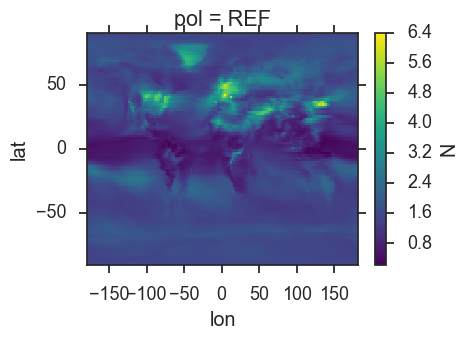

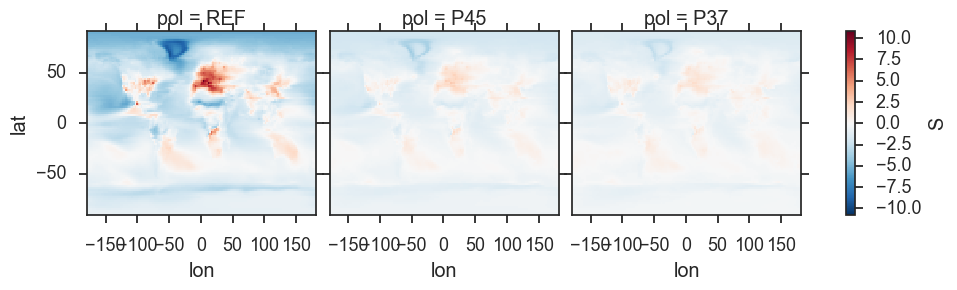

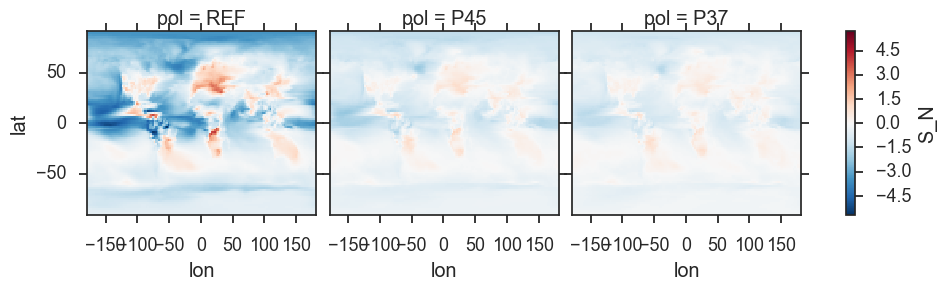

In [46]:
year = 2050
dyear = 5
ylo, yhi = year-dyear, year+dyear

_x = ens_avg_signal_ds['N'].isel(pol=0)
_x.plot.pcolormesh(x='lon', y='lat', size=3, infer_intervals=True)

_x = ens_avg_signal_ds['S'].sel(year=slice(ylo, yhi)).mean('year')
_x.plot.pcolormesh(x='lon', y='lat', col='pol', infer_intervals=True)

_x = ens_avg_signal_ds['S_N'].sel(year=slice(ylo, yhi)).mean('year')
_x.plot.pcolormesh(x='lon', y='lat', col='pol', infer_intervals=True)

### Time of emergence

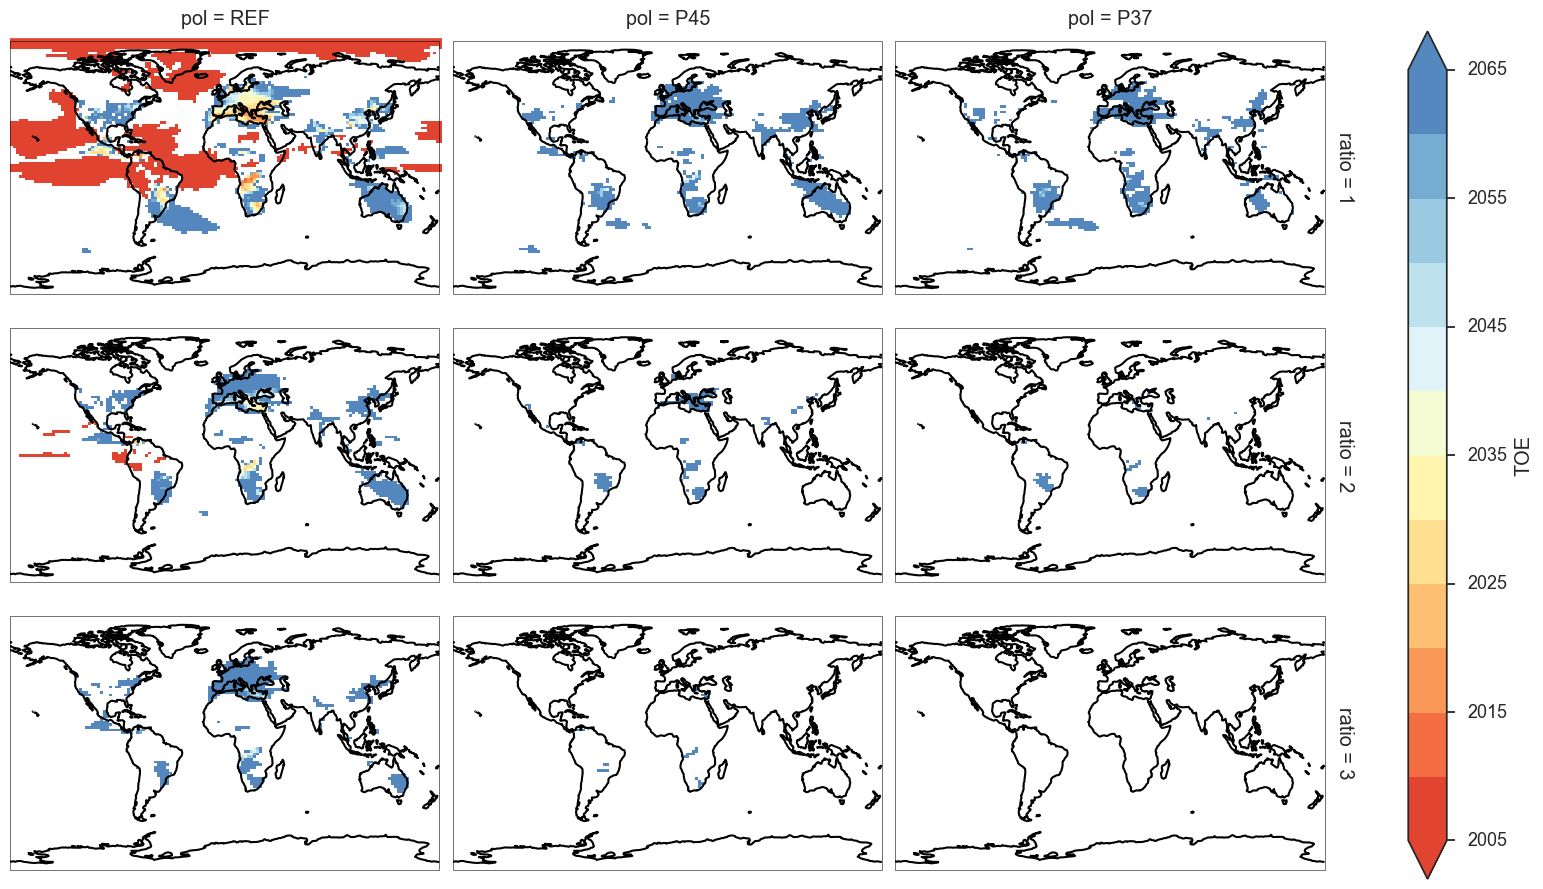

In [47]:
from darpy.plot import get_figsize

nrows, ncols = 3, 3
size, aspect = 3., 1.75 # 16./10.
figsize = get_figsize(nrows, ncols, size, aspect)

cmap_kws = dict(vmin=2005, vmax=2065, levels=13, cmap="RdYlBu",)

g = ens_avg_signal_ds['TOE'].plot.imshow(
    x='lon', y='lat', row='ratio', col='pol',
    infer_intervals=True,
    aspect=aspect, size=size, **cmap_kws,
    subplot_kws=dict(
        projection=ccrs.PlateCarree(),
        aspect='auto',
    ),
    transform=ccrs.PlateCarree(),
)
for ax in g.axes.ravel():
    ax.coastlines(lw=1.5)
    ax.set_aspect('auto', 'box-forced')
#     ax.outline_patch.set_visible(False)

fn = "../figs/hs2012/fgm.{}.{}.ens_mean.toe".format(field, season)
plt.savefig(fn+".pdf", transparent=True, bbox_inches='tight')
plt.savefig(fn+".png", transparent=True, bbox_inches='tight', dpi=300)

Plot just reference case, raito 1

/Users/daniel/anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in less
  if not reflexive


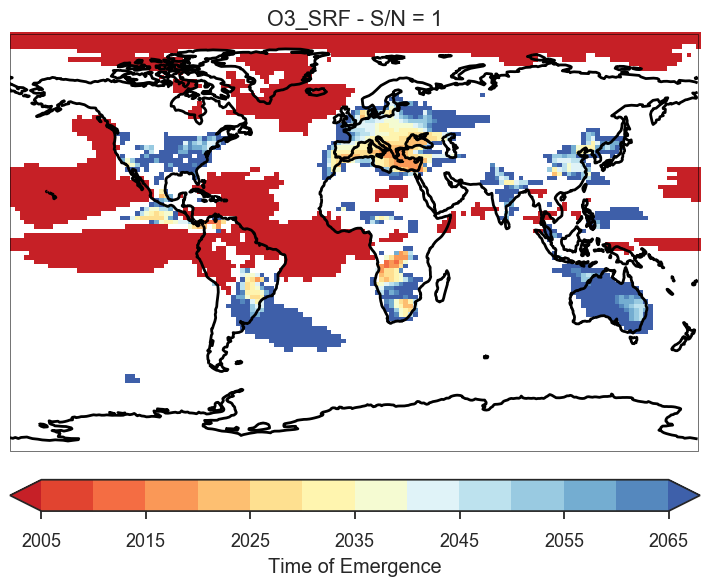

In [48]:
from darpy.plot import get_figsize

size, aspect = 6., 1.2
width, height = get_figsize(size=size, aspect=aspect)
fig, ax = plt.subplots(figsize=(width, height), 
                       subplot_kw=dict(projection=ccrs.PlateCarree(),
                                       aspect='auto'))

max_year = all_signals['TOE'].max_year
_y = all_signals.sel(pol='REF', ratio=1).mean('ic')['TOE']
_y = _y.where(_y < max_year)
_y.plot.imshow(
    x='lon', y='lat', ax=ax, #infer_intervals=True,
    **cmap_kws,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=dict(label="Time of Emergence", pad=0.05,
                     orientation='horizontal')
)

ax.coastlines(lw=2.)
ax.set_aspect('auto', 'box-forced')
ax.set_title("{} - S/N = 1".format(field))

plt.tight_layout()

fn = "../figs/hs2012/fgm.{}.{}.REF.S_N_1.toe".format(field, season)
plt.savefig(fn+".pdf", transparent=True, bbox_inches='tight')
plt.savefig(fn+".png", transparent=True, bbox_inches='tight', dpi=300)

Compare members for a single case

/Users/daniel/anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in less
  if not reflexive
/Users/daniel/anaconda/lib/python3.5/site-packages/cartopy/mpl/geoaxes.py:1339: RuntimeWarning: invalid value encountered in greater
  to_mask = ((np.abs(dx_horizontal) > np.pi / 2) |


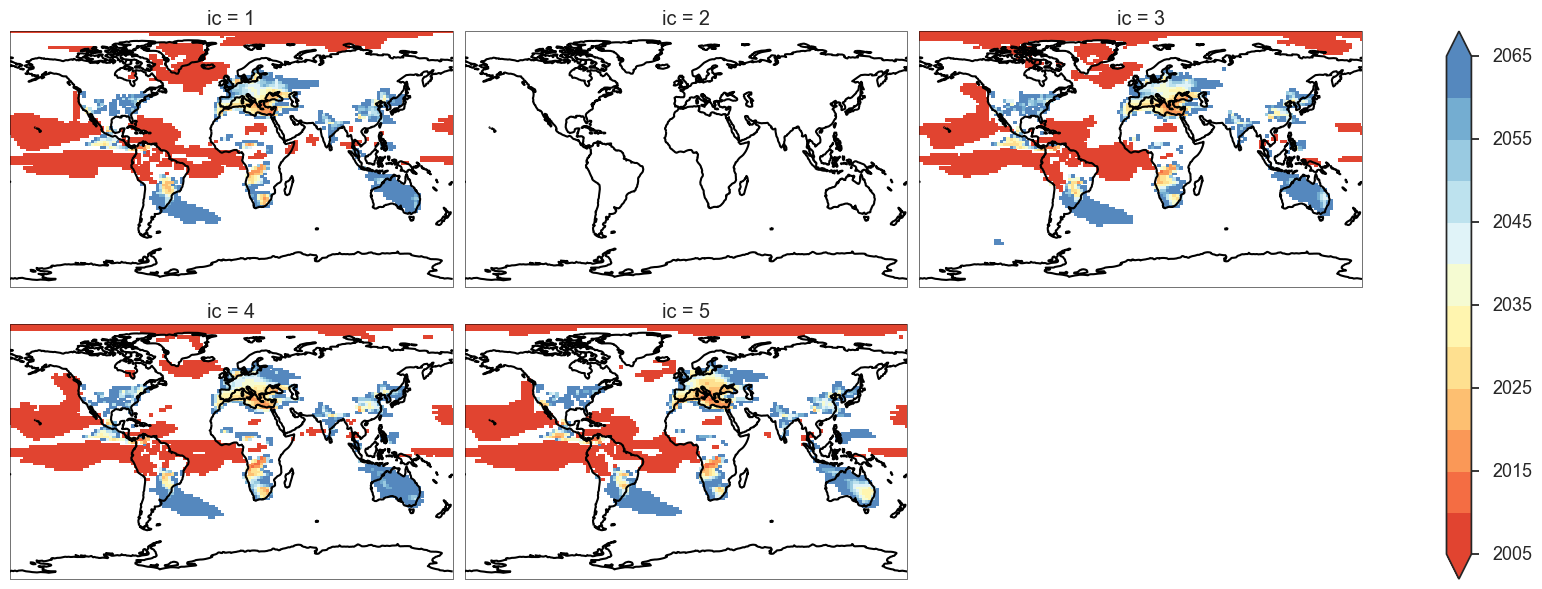

In [49]:
cmap_kws = dict(vmin=2005, vmax=2065, levels=13, cmap="RdYlBu",)

_y = all_signals.sel(pol='REF', ratio=1)['TOE']
_y = _y.where(_y < _y.max_year)
g = _y.plot.pcolormesh(
    x='lon', y='lat', col='ic', col_wrap=3, infer_intervals=True,
    aspect=1.8, **cmap_kws,
    subplot_kws=dict(
        projection=ccrs.PlateCarree(),
        aspect='auto',
    ),
    transform=ccrs.PlateCarree(),
)
for ax in g.axes.ravel():
    ax.coastlines(lw=1.5)
    ax.set_aspect('auto', 'box-forced')

### Uncertainty in ToE

At each grid cell, look at the spread in the 5 ensemble members.

In [127]:
toe_subset = all_signals['TOE']

spread_signal_ds = toe_subset.max('ic') - toe_subset.min('ic')
spread_signal_ds = spread_signal_ds.reindex(pol=['REF', 'P45', 'P37'])

spread_signal_ds = spread_signal_ds.where(spread_signal_ds > 0)

/Users/daniel/anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater
  if not reflexive


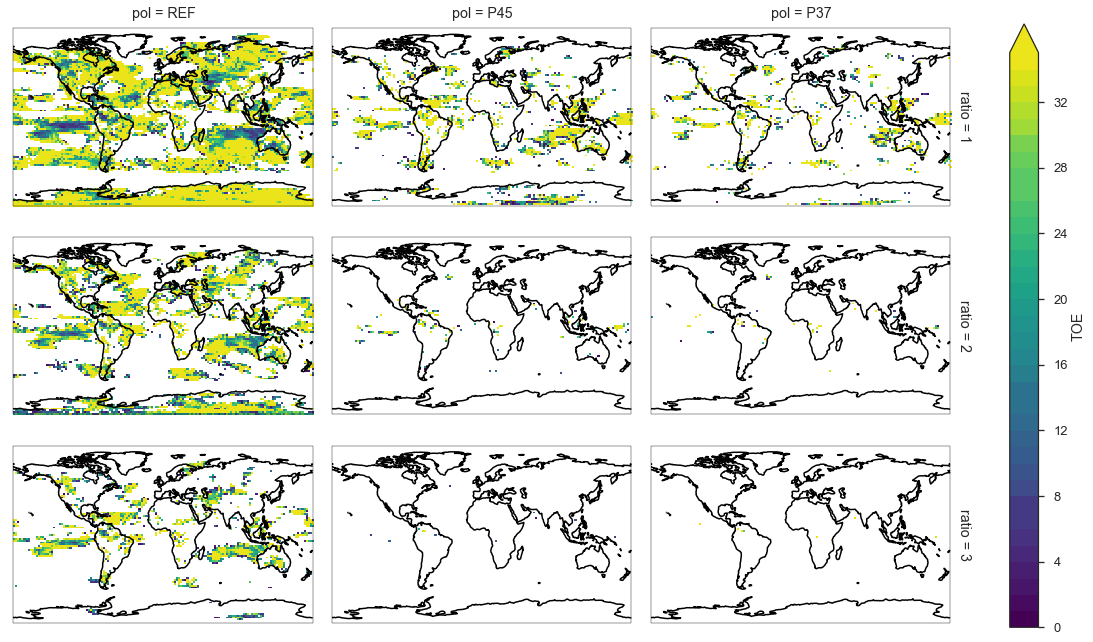

In [128]:
from darpy.plot import get_figsize
import cmocean

nrows, ncols = 3, 3
size, aspect = 3., 1.75 # 16./10.
figsize = get_figsize(nrows, ncols, size, aspect)

cmap_kws = dict(vmin=0, vmax=35, levels=36, cmap='viridis')

g = spread_signal_ds.plot.imshow(
    x='lon', y='lat', row='ratio', col='pol',
    infer_intervals=True,
    aspect=aspect, size=size, **cmap_kws,
    subplot_kws=dict(
        projection=ccrs.PlateCarree(),
        aspect='auto',
    ),
    transform=ccrs.PlateCarree(),
)
for ax in g.axes.ravel():
    ax.coastlines(lw=1.5)
    ax.set_aspect('auto', 'box-forced')
#     ax.outline_patch.set_visible(False)

fn = "../figs/hs2012/fgm.{}.{}.ens_range.toe".format(field, season)
plt.savefig(fn+".pdf", transparent=True, bbox_inches='tight')
plt.savefig(fn+".png", transparent=True, bbox_inches='tight', dpi=300)

# Regressions

We want to identify grid cells where similar trends in temperature and air quality are occurring over time. To do this, we'll eventually cluster on timeseries and timeseries metrics relating to these fields. We probably also want to take into account some form of distance metric, since near-clusters should be located near one another.

The simplest metric to look at is the timeseries correlation between our fields of interest

In [3]:
from darpy import shift_lons
from air_quality.util import fgm_unstack_years

fields = ['TREFHT', 'O3_SRF', 'PM25_ANT']
season = 'DJF'
scales = [1., 1e9, 1.]

data = []
for field, scale in zip(fields, scales):
    print(field)
    data.append(xr.open_dataset(
        "../data/processed/seasonal_timeseries/fgm.{}.{}.nc"
        .format(field, season)
    )*scale)
data = xr.auto_combine(data)
data = data.squeeze()

data = fgm_unstack_years(data)
data = shift_lons(data).roll(lon=len(data.lon)//2 - 1)

merged = data.copy()

TREFHT
O3_SRF
PM25_ANT


``` python
from darpy import shift_lons

fields = ['TREFHT', 'O3_SRF', 'PM25_ANT']
season = 'DJF'
scales = [1., 1e9, 1.]

data = []
for field, scale in zip(fields, scales):
    print(field)
    data.append(xr.open_dataset(
        "../data/processed/seasonal_timeseries/fgm.{}.{}.nc"
        .format(field, season)
    )*scale)
data = xr.auto_combine(data)
data = data.squeeze()

dec_dict = {}
decs = data.dec.values.astype(str)

for dec in decs:
    _d = data.sel(dec=dec).copy()
    low, hi = map(int, dec.split("-"))
    _d.time.values = range(low+1, hi+1)
    dec_dict[dec] = _d

pol_dict = {}
pols = data.pol.values.astype(str)

for pol in pols:
    _p = xr.concat([dec_dict['1980-2010'].sel(pol='REF'),
                    dec_dict['2035-2065'].sel(pol=pol),
                    dec_dict['2085-2115'].sel(pol=pol)],
                   dim='time')
    del _p['pol'], _p['dec']
    _p['pol'] = pol
    _p.set_coords(['pol', ], inplace=True)
    
    pol_dict[pol] = _p

merged = xr.auto_combine([pol_dict[pol] for pol in pols], 'pol')
merged = shift_lons(merged).roll(lon=len(merged.lon)//2 - 1)
``` 

One of the easiest things to do would just be to see the correlation between temperature and ozone at each grid cell. For the case of a single grid cell from a single simulation, that's pretty straightforward:

(0.13997594, 0.1882228718978772)


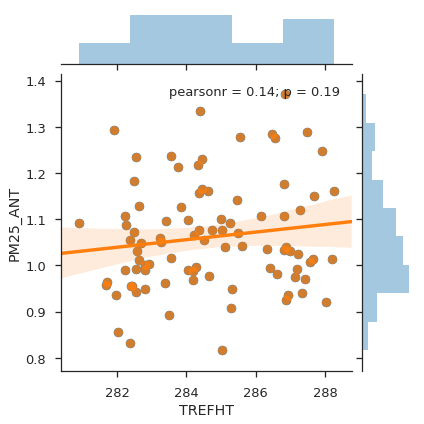

In [4]:
import seaborn as sns
from scipy.stats import pearsonr

ic = 1
pol = 'REF'
lat = 42
lon = -50

ts = (
    merged
    .sel(ic=ic, pol=pol)
    .sel(lat=lat, lon=lon, method='nearest')
    .to_dataframe()
    .reset_index()
)

x = ts['TREFHT'].values
y = ts['PM25_ANT'].values
print(pearsonr(x, y))

jg = sns.jointplot('TREFHT', 'PM25_ANT', ts)
jg.plot_joint(sns.regplot, marker=None)

Playing with this, there are starkly different correlations between O3 and T on land versus oceanic grid cells, so using some form of correlation metric should go a very long way here. Another potential metric could be to look at co-occurrence of extremes with nearby grid cells. I'm not 100% sure what the best way to do that would be... could possibly de-trend the timeseries of each and pick the years that given percentiles in the dataset occur at?

Now we craft a helper method to apply this over our dataset, ideally without stacking/unstacking.

**Annual Regression**

In [5]:
from air_quality.analysis import regress_fields

x = 'TREFHT'
y = 'O3_SRF'
new_data = regress_fields(
    merged,#.isel(ic=0, pol=0),# lat=slice(0, 50), lon=slice(0, 50)), 
    x, y)

In [16]:
import salem
import cmocean
d = new_data.r_O3_SRF_TREFHT.isel(ic=0, pol=0)
d = d.where(new_data.p_O3_SRF_TREFHT < 0.05)
print(d)
d.salem.quick_map(cmap=cmocean.cm.balance)

<xarray.DataArray (lat: 96, lon: 144, pol: 3, ic: 5)>
array([[[[-0.778304, ..., -0.778304],
         ..., 
         [-0.778304, ..., -0.778304]],

        ..., 
        [[-0.778244, ..., -0.778244],
         ..., 
         [-0.778244, ..., -0.778244]]],


       ..., 
       [[[-0.759368, ..., -0.759368],
         ..., 
         [-0.759368, ...,       nan]],

        ..., 
        [[-0.759368, ..., -0.759368],
         ..., 
         [-0.759368, ...,       nan]]]])
Coordinates:
  * pol      (pol) object 'REF' 'P37' 'P45'
  * ic       (ic) int64 1 2 3 4 5
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 -82.42 -80.53 -78.63 ...
  * lon      (lon) float64 -177.5 -175.0 -172.5 -170.0 -167.5 -165.0 -162.5 ...


ValueError: Data should be 2D.

In [ ]:
from scipy.stats import pearsonr
from numpy import corrcoef

test_data = merged.copy()#.sel(pol='REF', ic=2)
x = 'TREFHT'
y = 'O3_SRF'

all_dims = set(test_data.dims)
corr_dim = 'time'
stack_dims = list(all_dims - set([corr_dim, ]))

# Stack the data 
stack_dim = '_temp'
_stacked = test_data.stack(**{stack_dim: stack_dims})

# Transpose so that the stacked dimension is first - we do this because we will
# vectorize over the first dimension
_stacked = _stacked.transpose(stack_dim, corr_dim)
_x = _stacked[x].values
_y = _stacked[y].values
_time = _stacked['time'].values

# Vectorize the pearson correlation coefficient calculation; this will apply it
# over the first axis in our data, and return both the 'r' and associated 'p' values
vec_pearsonr = np.vectorize(pearsonr, signature='(n),(n)->(),()')
rs, ps = vec_pearsonr(_x, _y)

# Additionally, compute the linear trend components for the two variables.
ms_x, intcpts_x = np.polyfit(_time, _x.T, 1)
ms_y, intcpts_y = np.polyfit(_time, _y.T, 1)

# Copy the data into our data_array; we may not actually need to copy and could
# probably add it directly, but this is a bit safer.
new_data = _stacked.copy()
new_data['r_{}-{}'.format(y, x)] = xr.DataArray(rs, dims=[stack_dim, ])
new_data['p_{}-{}'.format(y, x)] = xr.DataArray(ps, dims=[stack_dim, ])
new_data['m_'+x] = xr.DataArray(ms_x, dims=[stack_dim, ])
new_data['m_'+y] = xr.DataArray(ms_y, dims=[stack_dim, ])
new_data['intcpt_'+x] = xr.DataArray(intcpts_x, dims=[stack_dim, ])
new_data['intcpt_'+y] = xr.DataArray(intcpts_y, dims=[stack_dim, ])

# Unstack to finalize the calculation
new_data = new_data.unstack(stack_dim)

In [ ]:
mean_ic = new_data['m_'+y].mean('ic')
adj = 100.*(new_data['m_'+y] - mean_ic) / mean_ic

In [ ]:
# field = 'r_{}-{}'.format(y, x)
field = 'm_' + y

new_data[field].plot.pcolormesh(
    x='lon', y='lat', col='pol', row='ic', 
    size=3., aspect=16./9., robust=True
)

plt.savefig("../figs/hs2012/fgm.{}.{}.all_cases.png"
            .format(field, season),
            dpi=100, transparent=True)